<a href="https://colab.research.google.com/github/NC25/gym_fishing/blob/master/fishing-v0/Current_Tuning_DQN_fishing_v_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import stable_baselines
stable_baselines.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'2.10.0'

# Packaging

In [ ]:
!git clone https://github.com/boettiger-lab/gym_fishing.git

fatal: destination path 'gym_fishing' already exists and is not an empty directory.


In [ ]:
!python gym_fishing/setup.py sdist bdist_wheel 

running sdist
running egg_info
writing gym_fishing.egg-info/PKG-INFO
writing dependency_links to gym_fishing.egg-info/dependency_links.txt
writing top-level names to gym_fishing.egg-info/top_level.txt
reading manifest file 'gym_fishing.egg-info/SOURCES.txt'
writing manifest file 'gym_fishing.egg-info/SOURCES.txt'

running check


creating gym_fishing-0.0.2
creating gym_fishing-0.0.2/gym_fishing.egg-info
copying files to gym_fishing-0.0.2...
copying gym_fishing.egg-info/PKG-INFO -> gym_fishing-0.0.2/gym_fishing.egg-info
copying gym_fishing.egg-info/SOURCES.txt -> gym_fishing-0.0.2/gym_fishing.egg-info
copying gym_fishing.egg-info/dependency_links.txt -> gym_fishing-0.0.2/gym_fishing.egg-info
copying gym_fishing.egg-info/top_level.txt -> gym_fishing-0.0.2/gym_fishing.egg-info
Writing gym_fishing-0.0.2/setup.cfg
Creating tar archive
removing 'gym_fishing-0.0.2' (and everything under it)
running bdist_wheel
running build
installing to build/bdist.linux-x86_64/wheel
running install
running 

In [ ]:
!pip install -e ./gym_fishing/

Obtaining file:///content/gym_fishing
  Found existing installation: gym-fishing 0.0.2
    Can't uninstall 'gym-fishing'. No files were found to uninstall.
  Running setup.py develop for gym-fishing


In [ ]:
!ls

build  dist  gym_fishing  gym_fishing.egg-info	sample_data


In [ ]:
!cd gym_fishing

In [ ]:
import gym_fishing

In [ ]:
import gym

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN

In [ ]:
# Remove warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

## Import policy, RL agent, Wrappers

In [ ]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines import DDPG, TD3
from stable_baselines.ddpg.policies import LnMlpPolicy
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise
from stable_baselines.common.callbacks import BaseCallback

In [ ]:
env = gym.make('fishing-v0')

In [ ]:
model = DQN(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=25000)
model.save("dqn_fishing-v0")

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 100      |
| mean 100 episode reward | 1.1      |
| steps                   | 3619     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 200      |
| mean 100 episode reward | 1.1      |
| steps                   | 5288     |
--------------------------------------


In [ ]:
#del model

model = DQN.load("dqn_fishing-v0")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [ ]:
obs = env.reset()
for i in range(100):
  action, _states = model.predict(obs)
  obs, rewards, dones, info = env.step(action)
  print("harvest: " + str(action) + "\n" + "obs: " + str(obs) + "\n" + str(rewards) + "\n" + str(dones) + "\n" + str(info))
  env.render()
  
env.close()

## Callback Function


In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

## Create and wrap the environment

We will be using Lunar Lander environment with continuous actions

In [ ]:
# Create log dir
log_dir = "/tmp/gym/".  
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('fishing-v0')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

## Define and train the DDPG agent

In [ ]:
# Add some param noise for exploration
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.1, desired_action_stddev=0.1)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = DQN(MlpPolicy, env, param_noise=param_noise, verbose=0)
# Train the agent
model.learn(total_timesteps=int(1e5), callback=callback)

In [ ]:
# Add some param noise for exploration
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.1, desired_action_stddev=0.1)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = DQN(MlpPolicy, env, param_noise=param_noise, verbose=1)
# Train the agent
model.learn(total_timesteps=int(1e5), callback=callback) 

In [ ]:
!pip install matplotlib

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

## Plotting helpers

Stable Baselines has some built-in plotting helper, that you can find in `stable_baselines.results_plotter`. However, to show how to do it yourself, we are going to use custom plotting functions. 

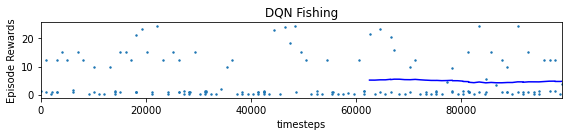

In [ ]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DQN Fishing")

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


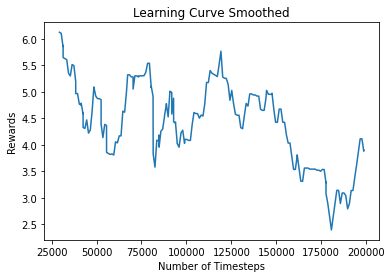

In [ ]:
plot_results(log_dir)

In [ ]:
import numpy as np

In [ ]:
from stable_baselines.common.vec_env import DummyVecEnv

In [ ]:
from stable_baselines.bench import Monitor
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.results_plotter import load_results, ts2xy

In [ ]:
from stable_baselines import A2C, SAC, PPO2, TD3

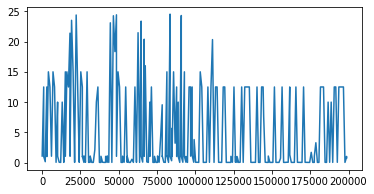

In [ ]:

class PlottingCallback(BaseCallback):
    """
    Callback for plotting the performance in realtime.

    :param verbose: (int)
    """
    def __init__(self, verbose=1):
        super(PlottingCallback, self).__init__(verbose)
        self._plot = None

    def _on_step(self) -> bool:
        # get the monitor's data
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if self._plot is None: # make the plot
            plt.ion()
            fig = plt.figure(figsize=(6,3))
            ax = fig.add_subplot(111)
            line, = ax.plot(x, y)
            self._plot = (line, ax, fig)
            plt.show()
        else: # update and rescale the plot
            self._plot[0].set_data(x, y)
            self._plot[-2].relim()
            self._plot[-2].set_xlim([self.locals["total_timesteps"] * -0.02, 
                                   self.locals["total_timesteps"] * 1.02])
            self._plot[-2].autoscale_view(True,True,True)
            self._plot[-1].canvas.draw()
        
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env('fishing-v1', n_envs=1, monitor_dir=log_dir)

plotting_callback = PlottingCallback()
        
model = PPO2('MlpPolicy', env, verbose=0)
model.learn(20000, callback=plotting_callback)